In [1]:
##### Importando Bibliotecas: #####
from random import randint
import pandas as pd
import numpy as np
import random
import time
import csv
import os
import re


##### Definindo as variáveis: #####

    #Nome das Colunas dos Dataframes:
n_WiA, p_WcA, n_WiB, p_WcB, p_AcT, p_BcT  = 'n(Wk∩A)', 'p(Wk|A)', 'n(Wk∩B)', 'p(Wk|B)', 'p(A|T)', 'p(B|T)'
    #Sendo:
        # n_WiA = n(Wk∩A) e n_WiB = n(Wk∩B)
        # p_WcA = P(W|A) e p_WcB = P(W|B)

    #Nome das categorias de tipos de emails:
nomeA, nomeB = 'ham','spam'

##### Símbolos:

<img src="simb.png">

___

# Ciência dos Dados - PROJETO 2

___
## Nomes:  Gabriel Couto, Gabriel Miras e Mariana Abrantes
___

## Introdução:

### Para criar o classificador:<br>
__1) Limpamos os emails da seguinte forma:__ <br>
* Convertemos todos os caracteres pra minúsculos<br>
* Trocamos todos caracteres que não são letras do alfabeto americano por espaços<br>
* Removemos todas palavras com menos de 2 caracteres de comprimento <br>
* Removemos os espaços excedentes<br>

Outras transformações que poderiam ser feitas:<br>
* Tirar preposições e artigos dos emails <br>
* Considerar palavras de mesmo significado e sufixos diferentes como as mesmas (Ex: election, elections, elected)<br>
<br>

__2) Separamos os dados em 2 novos dataframes:__ <br>
* Treinamento: Com 75% dos emails do dataframe original, será usado para gerar a tabela de frequências de palavras <br>
* Teste: Com 25% dos emails do dataframe original, será usado no classificador para calcular se o email é spam ou não<br>
<br>

__3) Criamos uma tabela de frequência de palavras associada à sua probabilidade de ser Spam ou não__<br>
a) Calculamos p(A) e P(B):
$$p(A) = \frac{n(A)}{totalEmails} \:\:\:\:\: \: p(B) = \frac{n(B)}{totalEmails}$$

b) Considerando a probabilidade de cada palavra como eventos independentes, sendo T o texto do email com m palavras (W1,W2,...,Wm): $$ p(T) = p(W_1)\times p(W_2) \times \dots \times p(W_m) \: \Longrightarrow p(T|A) \: = p(W_1|A) \times p(W_2|A) \times \dots \times p(W_m|A) $$<br>

Não podemos ter nenhuma palavra com p(Wk|A) igual a zero para não zerar p(T|A), para isso usamos Laplace Smoothing. <br>
Fazemos isso adicionando 1 ao numerador de p(Wk|A) e palavrasD no denominador:
$$ p(W_k|A) = \dfrac{n(W_k∩A)}{palavrasA} \longrightarrow p(W_k|A) = \dfrac{n(W_k∩A)+1}{palavrasA+palavrasD}$$
Analogamente, para B: $$ p(W_k|B) = \dfrac{n(W_k∩B)+1}{palavrasB+palavrasD}$$

Criamos uma tabela com as palavras do treinamento como índices e as colunas: p(Wk|A) e p(Wk|B) <br>
<br> 

__4) Criamos o classificador Naive-Bayes para através da tabela de frequências gerada classificar o email como spam ou não__<br>
Do teorema de Bayes: 
$$p(A|T)\times p(T) = p(T|A)\times p(A) \Longrightarrow P(A|T) =  p(W_1|A) \times \dots \times p(W_m|A) \times \dfrac{p(A)}{p(T)} $$
Analogamente, o mesmo vale para B, basta trocar A por B na equação acima<br>

As palavras que não estiverem na tabela de frequências tem p(W|A) e p(W|B) = 1/palavrasD<br>

Como vamos comparar p(A|T) e p(B|T) podemos simplificar dividindo os dois lados da equação por p(T) e poderemos usar as relações: $$P(A|T) =  p(A) \times p(W_1|A) \times \dots \times p(W_m|A) $$
$$P(B|T) =  p(B) \times p(W_1|B) \times \dots \times p(W_m|B) $$ <br>
Se p(A|T) > p(B|T) o email é do tipo A <br>
Se p(A|T) < p(B|T) o email é do tipo B <br>


### Para analizar o classificador:
__1) Alterando a base de treinamento:__<br>
Existem várias combinações de emails possíveis de modo a obter uma amostra de treinamento com 75% dos emails do dataframe.
Por isso, para observar como o valor dos percentuais de acerto variam com a amostra escolhida realizamos o procedimento 10 mil vezes para amostras ao acaso e salvamos os resultados obtidos numa lista.<br>

__2) Do histograma no final da página:__<br>
Temos que o histograma da taxa de acerto do classificador possui uma distribuição semelhante a uma distribuição normal, variando aproximadamente de 93 até 98, com média aproximada 95 e desvio padrão 0.49. Como o desvio padrão é pequeno comparado à taxa de acerto, o classificador mostrou-se confiável na maioria dos casos com uma só amostra. Contudo, podemos tornar o resultado ainda mais confiável e minimizar erros dividindo a base de dados em treinamento e teste mais de uma vez.
_______

___
## 1. Problema

O Classificador Naive-Bayes, o qual se baseia no uso do teorema de Bayes, é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser SPAM considerando as palavras em seu conteúdo e, de forma complementar, permite calcular a probabilidade de uma mensagem ser HAM dada as palavras descritas na mensagem.

Para realizar o MVP (minimum viable product) do projeto, você precisa programar uma versão do classificador que "aprende" o que é uma mensagem SPAM considerando uma base de treinamento e comparar o desempenho dos resultados com uma base de testes. 

___
## 2. Separação da base de dados em Treinamento e Teste

A base de dados deve ser separada em duas partes, aleatoriamente, considerando: 
    
    75% dos dados para a parte Treinamento; e 25% dos dados para a parte Teste.

In [39]:
#Carregar dados:
leitura = pd.ExcelFile('spamham2019(1).xlsx')
dados = pd.read_excel(leitura)

percentTreino = 0.75 #Proporção entre o comprimento do treinamento o dataframe dados.

#SEPARAR EM TREINO E TESTE
treinoOrig = dados.sample(frac=percentTreino,random_state=randint(0,100000))
testeOrig = dados.drop(treinoOrig.index)

#Cria índices numéricos pros dataframes
treinoOrig.index, testeOrig.index = range(len(treinoOrig)),range(len(testeOrig))

#  Limpando a base de dados

#### 1) Para usar o mesmo filtro para diferentes dataframes a função limparDados

In [40]:
def limparDados(df):   
    #Cria uma cópia do dataframe pra não adulterar os originais
    dfLimpo = df.copy(deep=True)
    
    #Pega cada linha de df:
    for numLinha in range(len(dfLimpo)):
        linha = dfLimpo.loc[numLinha,'Email'].lower() #Linha com tudo em minúsculo
        
        #Subtitui caracteres que não forem letras ou espaços por espaços:
        linhaL = re.sub(r"[^a-z ]",' ',linha)
        
        palavrasFiltradas=[]
        #Para cada palavra da linha de df:
        for palavra in linhaL.split(' '):
            palavraLimpa = re.sub(r"[^a-z]",'',palavra)
            
            #Se a palavra tiver mais que 1 caractere:
            if len(palavraLimpa) > 1:
                palavrasFiltradas.append(palavraLimpa)

        #Transformando em linha de novo
        linhaLimpa = " ".join(palavrasFiltradas)
        dfLimpo.loc[numLinha,'Email'] = linhaLimpa
    return(dfLimpo)

##### 2) Criar tabela de frequências de cada palavra:

In [41]:
#Carregar dados:
leitura = pd.ExcelFile('spamham2019(1).xlsx')
dados = pd.read_excel(leitura)
dadosL = limparDados(dados)
teste, treino = limparDados(testeOrig), limparDados(treinoOrig)

In [42]:
freq = {} #Tabela de frequências 
pA,pB = (len(dados[dados.Class==nomeA]))/(len(dados)),(len(dados[dados.Class==nomeB]))/(len(dados))

for numLinha in range(len(treino.Email)): 
    for palavra in treino.loc[numLinha,'Email'].split(' '):
        if palavra not in freq:
            freq[palavra] = {n_WiA:0, n_WiB:0, p_WcA:0,p_WcB:0}
        if treino.loc[numLinha,'Class'] == nomeA:
            freq[palavra][n_WiA] +=1
        else:
            freq[palavra][n_WiB] +=1

palavrasA, palavrasB, palavrasD = 0, 0, len(freq)
for key,valor in freq.items():  
    palavrasA += valor[n_WiA]
    palavrasB += valor[n_WiB]

for palavra,valor in freq.items():  
    freq[palavra][p_WcA] = (valor[n_WiA]+1)/(palavrasA+palavrasD) #Laplace Smoothing
    freq[palavra][p_WcB] = (valor[n_WiB]+1)/(palavrasB+palavrasD) #Laplace Smoothing
        
# Transformando a tabela num dataframe:
tabelapalavras = pd.DataFrame(freq).T
tabelapalavras.head(10)

,n(Wk∩A),n(Wk∩B),p(Wk|A),p(Wk|B)
ok,214.0,4.0,0.004103,0.000262
lar,32.0,0.0,0.000630,0.000052
double,5.0,13.0,0.000115,0.000732
check,29.0,3.0,0.000573,0.000209
wif,19.0,0.0,0.000382,0.000052
da,118.0,1.0,0.002271,0.000105
hair,17.0,0.0,0.000344,0.000052
dresser,2.0,0.0,0.000057,0.000052
already,70.0,1.0,0.001355,0.000105
he,175.0,0.0,0.003359,0.000052


In [43]:
print('PalavrasA:',palavrasA,'| PalavrasB:',palavrasB, '| PalavrasD:',len(freq))
print('p(A):',round(pA,7),'| p(B):',round(pB,5))

PalavrasA: 45833 | PalavrasB: 12551 | PalavrasD: 6567
p(A): 0.8659368 | p(B): 0.13406


___
## 3. Classificador Naive-Bayes

In [44]:
mensagens={}

for numLinha in range(len(teste.Email)):   
    mensagens[numLinha] = {'Email original':testeOrig.loc[numLinha,'Email'],'Email Filtrado':teste.loc[numLinha,'Email'],
                           'Classe original':testeOrig.loc[numLinha,'Class'],p_AcT:0,p_BcT:0}
    
    pAcT,pBcT=1,1
    for palavra in teste.loc[numLinha,'Email'].split(' '):    
        if palavra in tabelapalavras.index:
            pAcT*= tabelapalavras.loc[palavra,p_WcA]
            pBcT*= tabelapalavras.loc[palavra,p_WcB]
        else:
            pAcT*= 1/(palavrasA +len(freq))
            pBcT*= 1/(palavrasB + len(freq))
    
        mensagens[numLinha][p_AcT] = pAcT*pA
        mensagens[numLinha][p_BcT] = pBcT*pB

    if pAcT >= pBcT:
        mensagens[numLinha]['Classe calculada'] = nomeA
    if pAcT < pBcT: 
        mensagens[numLinha]['Classe calculada'] = nomeB

#Para melhorar a visualização dos emails colocamos ela num dataframe:
tabelaEmails = pd.DataFrame(mensagens).T

tabelaEmails.head()

,Classe calculada,Classe original,Email Filtrado,Email original,p(A|T),p(B|T)
0,ham,ham,gonna be home soon and don want to talk about ...,I'm gonna be home soon and i don't want to tal...,3.32347e-53,1.20913e-62
1,ham,ham,have date on sunday with will,I HAVE A DATE ON SUNDAY WITH WILL!!,2.37507e-17,9.70022e-19
2,ham,ham,fine if that the way feel that the way its gota,Fine if thatåÕs the way u feel. ThatåÕs the wa...,5.05452e-30,1.82017e-39
3,ham,ham,going to try for months ha ha only joking,I‰Û÷m going to try for 2 months ha ha only joking,2.59569e-28,3.47857e-31
4,ham,ham,lol your always so convincing,Lol your always so convincing.,5.51899e-16,2.42515e-19


In [45]:
VerHam, VerSpam, FalHam, FalSpam = 0,0,0,0
for numLinha in range(len(mensagens)):
    #Negativo Verdadeiro
    if (tabelaEmails.loc[numLinha,'Classe original'] == nomeA)&(tabelaEmails.loc[numLinha,'Classe calculada'] == nomeA): 
        VerHam+=1
    #Positivos Verdadeiros
    if (tabelaEmails.loc[numLinha,'Classe original'] == nomeB)&(tabelaEmails.loc[numLinha,'Classe calculada'] == nomeB):
        VerSpam+=1
    #Falso Negativo
    if (tabelaEmails.loc[numLinha,'Classe original'] == nomeB)&(tabelaEmails.loc[numLinha,'Classe calculada'] == nomeA): 
        FalHam+=1
    #Falsos Positivos
    if (tabelaEmails.loc[numLinha,'Classe original'] == nomeA)&(tabelaEmails.loc[numLinha,'Classe calculada'] == nomeB): 
        FalSpam+=1

#Positivo = ham | Negativo = spam 
print('Positivos Verdadeiros (Verdadeiros Spam): ',VerSpam)
print('Negativos Verdadeiros (Verdadeiros Ham): ',VerHam)
print('Falsos Positivos (Ham calculados como Spam):',FalSpam)
print('Falsos Negativos (Spam calculados como Ham): ',FalHam)
print()
print('Precisão de acertos:',round(100*(VerSpam+VerHam)/(VerHam+VerSpam+FalHam+FalSpam),3),'%')

Positivos Verdadeiros (Verdadeiros Spam):  143
Negativos Verdadeiros (Verdadeiros Ham):  1196
Falsos Positivos (Ham calculados como Spam): 45
Falsos Negativos (Spam calculados como Ham):  9

Precisão de acertos: 96.123 %


## 4. Qualidade do Classificador alterando a base de treinamento
Para fazermos o loop simplificamos o código ao máximo para reduzir o tempo de cada iteração:
Fazendo algumas mudanças e preferencialmente trabalhando com dicionário em vez de dataframe fazemos o tempo de cada iteração cair de 0.4s para 0.06s.

In [13]:
#Função que recebe:
    #n = número de resultados à serem obtidos
    #dadoz = dataframe limpo (após passar por limparDados)
    
def loop(n,dadosz):
    resultados=[]
    
    start = time.time()
    for j in range(n):
        treinoOrigz=dadosz.sample(frac=percentTreino,random_state=randint(0,100000))
        testeOrigz=dadosz.drop(treinoOrigz.index)

        #Criar índices e preparar teste e treino:
        treinoOrigz.index,testeOrigz.index  = range(len(treinoOrigz)), range(len(testeOrigz))
        testez, treinoz = testeOrigz.copy(deep=True), treinoOrigz.copy(deep=True)

        pA, pB = (len(treinoz[treinoz.Class==nomeA]))/(len(treinoz)), (len(treinoz[treinoz.Class==nomeB]))/(len(treinoz)) 
        
        
        ###### FREQUÊNCIAS DAS PALAVRAS ######
        freq = {} #Tabela de frequências 

        #Para reduzirmos o tempo de execução transformamos o dataframe num dicionário
        dicionas=treinoz.to_dict()

        for numLinha in range(len(dicionas['Email'])): 

            for palavra in dicionas['Email'][numLinha].split(' '):
                if palavra not in freq:
                    freq[palavra] = {n_WiA:0,n_WiB:0,p_WcA:0,p_WcB:0}
                if dicionas['Class'][numLinha] == nomeA:
                    freq[palavra][n_WiA] +=1
                else:
                    freq[palavra][n_WiB] +=1

        #Contagens:       
        palavrasA,palavrasB = 0,0
        for key,valor in freq.items():  
            palavrasA += valor[n_WiA]
            palavrasB += valor[n_WiB]

        for palavra,valor in freq.items():   
            freq[palavra][p_WcA] = (valor[n_WiA]+1)/(palavrasA+len(freq)) #Laplace Smoothing
            freq[palavra][p_WcB] = (valor[n_WiB]+1)/(palavrasB+len(freq)) #len(freq) = Nº palavras distintas


        ###### CLASSIFICADOR ######
        mensagens={}
        lTesteOClass = list(testeOrigz.loc[:,'Class'])
        lTesteCEmail = list(testez.loc[:,'Email'])
        
        for numLinha in range(len(testez)):   
            mensagens[numLinha] = {'Classe original':lTesteOClass[numLinha],p_AcT:0,p_BcT:0}

            pAcT,pBcT=1,1
            for palavra in lTesteCEmail[numLinha].split(' '):    
                if palavra in freq.keys():
                    pAcT*= freq[palavra][p_WcA] 
                    pBcT*= freq[palavra][p_WcB] 
                else:
                    pAcT*= 1/(palavrasA +len(freq))
                    pBcT*= 1/(palavrasB + len(freq))

            mensagens[numLinha][p_AcT] = pAcT*pA
            mensagens[numLinha][p_BcT] = pBcT*pB

            if pAcT >= pBcT:
                mensagens[numLinha]['Classe calculada'] = nomeA
            if pAcT < pBcT: 
                mensagens[numLinha]['Classe calculada'] = nomeB

        acertos = 0 
        for k in range(len(mensagens)):
            if mensagens[k]['Classe original'] == mensagens[k]['Classe calculada']:
                acertos+=1

        resultados.append(round(100*acertos/len(mensagens),3))
        j+=1
    end = time.time()
    print("Tempo médio por iteração:",round(1000*(end-start)/n,4),'ms  | Tempo total:',(end-start),'s')
    return resultados

In [17]:
repeticoes = 10000
passa = loop(repeticoes,dadosL)

Tempo médio por iteração: 36.2393 ms  | Tempo total: 362.39269161224365 s


##### Histograma dos 10 mil resultados:

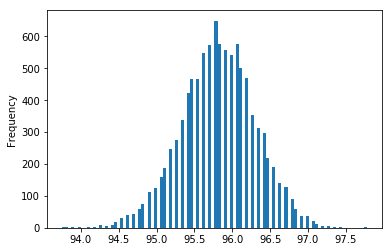

In [25]:
sResult= pd.Series(data=passa)
sResult.plot.hist(bins=100)

Obtemos uma distribuição semelhante a uma distribuição normal simétrica.

In [49]:
sResult.describe()

count    10000.000000
mean        95.813637
std          0.488336
min         93.754000
25%         95.477000
50%         95.836000
75%         96.123000
max         97.775000
dtype: float64